<a href="https://colab.research.google.com/github/kozltv/pMA_stabilnost/blob/main/pMA_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import numpy as np
#!pip install mne
import mne
import pandas as pd
import matplotlib.pyplot as plt

#!pip install ipympl
%matplotlib widget #notebook
%matplotlib inline

In [ ]:
#!ipython notebook --pylab=inline
#!conda install -c conda-forge/label/cf202003 nodejs
#!conda install -y nodejs
#!pip install ipympl
#!pip install --upgrade jupyterlab
#!jupyter labextension install @jupyter-widgets/jupyterlab-manager
#!jupyter labextension install jupyter-matplotlib
!jupyter nbextension enable --py widgetsnbextension

## functions

In [ ]:
%matplotlib qt

In [ ]:
!~/.ipython/

/bin/bash: /root/.ipython/: Is a directory


###1.1. Find movement 
Функция должна фильтроваль только указанную мышцу. иначе перерасход ресурсов.


In [ ]:
def find_movement(raw, time, mscl, window, thrs, thrs2, positive):
    '''Find movement

    arguments: 
      raw: DataFrame, datatset from mne function for brainproducts file reading
      time: list with [start, end], contains start and end of raw data to analise
      mscl: str, name of EMG chanel
      window: int, window size in ms 
      thrs: int, threshold in uV to find movement start in the whole signal
      thrs2:  int, threshold in uV to find more accurate movement start/end moment in the window 
          where movement started/ended based in thrs
      positive: float, percentage of ticks in the window which should be less or eaqual
          to thrs/thrs2
    '''
    
    # 0. Select data
    # ms to select time window to find movement start (ms)
    try:
        start = time[0]
        end=time[1]
    except:
        start = time[0]
        end = raw.to_data_frame().time.max()

    #filters
    # low cutoff
    low = 5
    # high cutoff
    high = 2200
    alldata = raw.filter(l_freq=low, h_freq=high, verbose=False).to_data_frame()
    dat = alldata[(alldata.time>=start)&(alldata.time<=end)]

    
    # lists to save information  - do not change
    time = []
    cond_result = []
    result = []

    # 1. Sliding window to check condition 
    for m in range(dat.time.min(), dat.time.max()):

        # selects data in the time window
        wnd = np.abs(dat[(dat.time>=m)&(dat.time<=m+window)][mscl])

        # check whether Share of picks higher than "thrs" is more than "positive" in the window
        cond = np.where(wnd>=thrs, 1, 0).sum()/len(wnd)>=positive 

        # save condition check result (True, False) and first timestamp of the window
        cond_result.append(cond)
        time.append(m)

        # save first timestamps of windows where cond was True
        if cond == True:
            result.append(m)


    # 2. Find "start" and "end" of movement
    result3 = pd.DataFrame({'times':time, 'result':cond_result})
    result3['previous'] = result3.result.shift(1)
    result3['change'] = result3.result - result3.previous

    trig = result3[result3.change.isin([1,-1])].reset_index(drop=True)
    trig['movement'] = np.where(trig.change==1, 'start', 'end')



    # 3. select times in the suitable windows preciselly 
    res = []
    for tr in trig.times:
        wnd = np.abs(dat[(dat.time>=tr)&(dat.time<=tr+window)])

        if trig[trig.times==tr].movement.values[0] == 'start':
            # select time when uV achived thrs first
            first = wnd[wnd[mscl]>=thrs2].time.min()
            res.append(first)
        else: 
            last = wnd[wnd[mscl]>=thrs2].time.max()
            res.append(last)
            
    return res, dat

a = np.array([1,2,3,4,5,6,7,8,9],dtype=int)
print(a > 3)
print(a[a > 3])


In [ ]:
def plot_signal(data, movement_time):
    """
    Interactive plot to see movement start closer

    Arguments:
      data: DataFrame with EMG by channels
      movement_time: array with times of movement start/end
    """

    fig, (ax0) = plt.subplots(nrows=1)
    for r in movement_time:
        ax0.axvline(x=r, color='r')

    ax0.plot(data.time, data[mscl], label='signal')
    ax0.legend()
    
    
def plot_emg_events(raw, movement_time):
    """
    MNE Interactive plot to see whole EMG with movement time markups

    Arguments:
      raw: emg file
      movement_time: array with times of movement start/end
    """
    # create event list from movemet_times and name each event with order number
    events = pd.DataFrame({'time':np.array(movement_time)*5, 'event_value':1, 'event_name':list(range(1,len(np.array(movement_time))+1))})
    raw.plot(n_channels=1, event_color='red', 
             events=np.array(events), 
             scalings=1e-3, 
             highpass=10, lowpass=2200)
    
def create_events(movement_time):
    """
    Creates event list from movemet_times and name each event with order number

    Arguments:
      movement_time: array with times of movement start/end
    """
    events = pd.DataFrame({'time':np.array(movement_time), 'event_value':1, 'event_name':list(range(1,len(np.array(movement_time))+1))})
    return events

    

from ipywidgets import widgets  
from ipywidgets import interact, interactive, fixed, interact_manual 

def adjust_movements(ev):
    """
    Interactive program based on widgets to Manually adjast Algo movement markups

    Arguments:
      ev: array with time of movement markups which are need to be adjasted
    """
    
    #raw file to dataframe
    data = raw.filter(l_freq=5, h_freq=2200, verbose=False).to_data_frame()
    
    # create widget to list events with button 'next event'
    button=widgets.Button(
        value=False,
        description='Next event',
        disabled=False,
        button_style='', # 'success', 'info', 'warning', 'danger' or ''
        tooltip='Description',
        icon='Saved' # (FontAwesome names without the `fa-` prefix)
                        )

    
    l = [] # for loop - indexes list of redo events 
    new_ts = [] # list to save new times stamp

    def plus(sender):
        l.append(1)
        index = np.array(l).sum()
        try:
            
            # create windget to Change event position
            w = widgets.FloatText(
            value=ev[index-1],
            min=ev[index-1]-800,
            max=ev[index-1]+3000,
            step=5,
            description='New Value uV:',
            disabled=False,
            continuous_update=False,
            orientation='horizontal',
            )
            
            # function for visualisation of new timestamp based on windget to Change event position
            def f(x):
                fig, (ax0) = plt.subplots(nrows=1)
                ax0.axvline(x=x, color='r')
                ax0.plot(data[(data.time>=ev[index-1]-800)&(data.time<=ev[index-1]+3000)].time, 
                         data[(data.time>=ev[index-1]-800)&(data.time<=ev[index-1]+3000)][mscl], label='signal') 

            
            # create Button to save new position
            b=widgets.Button(
                value=False,
                description='Save timestamp',
                disabled=False,
                button_style='', # 'success', 'info', 'warning', 'danger' or ''
                tooltip='Description',
                icon='Saved' # (FontAwesome names without the `fa-` prefix)
                )
            
            
            saved_ts=[] # new timestamp list
            
            # function of button 'save timestemp' - it saves new value to the list
            def but(sender):
                saved_ts.append(w.value)

            b.on_click(but)
            display(b,interactive(f, x=w))
            new_ts.append(saved_ts)
            
        except Exception as e:
            print("You finished")


    button.on_click(plus)
   

    
    return display(button),new_ts


from oauth2client.service_account import ServiceAccountCredentials
import gspread_dataframe as gsp
import gspread

# 1. SET UP GOOGLE SHEET API
# ----------- CHANGE CREADENTIALS LOCATION ------------------------

current_dir = '/content'
GSPREAD_KEYS_PATH = current_dir + '/esoteric-pad-326113-4ab241befdd8.json' # this is the directory where your file with key located
 

# Some functions for authorizing (no need to change something here)
def authorize_at_gspread(gspread_key_path=GSPREAD_KEYS_PATH):
    """
    Return authorized gspread object
    :param gspread_key_path: path to credentials key
    :return: gc object
    """
    scope = ['https://spreadsheets.google.com/feeds']
    credentials = ServiceAccountCredentials.from_json_keyfile_name(GSPREAD_KEYS_PATH, scope)
    gc = gspread.authorize(credentials)
    return gc
# authorization
authorize_at_gspread()


# 2. Function for particular sheet connection
def get_workbook(workbook_url, gspread_key_path=GSPREAD_KEYS_PATH):
    """ Returns GSPREAD object with opened workbook.
    Just open worksheet by referring to .worksheet(name) or use gspread_dataframe to load dataframe.
    """
    gc = authorize_at_gspread(gspread_key_path=gspread_key_path)
    return gc.open_by_url(workbook_url)


# Damir - to write to a sheet fucntion
def tospreadsheet (df, workbook_link, header = 'Title', key = 'new'):
    """Import dataframe to google spreadsheet by link
    Args: 
        df: imported dataframe
        workbook: link to dataframe
        header: header of worksheet 
        key: default 'new'
        if you want to use existing worksheet pass 'to existing sheet'

    """
    if key == 'new':
        workbook = get_workbook(workbook_link)
        wks = workbook.add_worksheet(header, len(df.index),len(df.columns))
        gsp.set_with_dataframe(wks, df, row = 1, col =1, include_column_header=True)

    elif key == 'existing':
        workbook = get_workbook(workbook)
        wks = workbook.worksheet(header)
        gsp.set_with_dataframe(wks, df, row = 1, col =1, include_column_header=True)
        

def gsheet(header,new_t):
    
    new = pd.DataFrame({'events_to_correct':redo})
    new2=pd.concat([new, pd.DataFrame(new_t[1])], axis=1).set_index('events_to_correct')

    result = events[['time','event_name']].set_index('event_name')

    final = pd.concat([result,new2],axis=1)
    final['muscle'] = mscl
    final['file'] = path[-20:path.find('.vhdr')][path[-20:path.find('.vhdr')].find('/')+1:]
    final['final_corrected_movement_time'] = np.where(final[0].isna==False,final[0],final.time )
    
    link = 'https://docs.google.com/spreadsheets/d/1g0wJeyONCuivtppNc352MBkBIyOgY7FxkQq5XgaBjsg/edit?usp=sharing'

    tospreadsheet(final, link, header)

    return final


__Notebook  widgets set up commands and libraries (allow to plot interractive charts - essencial for "Plot emg"):__

## Uppload data

Contact google driver

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

root_path = 'My Drive/participants/'

Mounted at /content/drive


In [ ]:
# 1. file path
#path = '/Users/ksenia.kozlova/Downloads/New trial/PoAn_12/PoAN_APB_3.vhdr'
path = '/content/PoAn/PoAn_APB_3.vhdr'
#path = 'drive/My Drive/participants/VaGe_25/rADM_70max_2.vhdr'

raw = mne.io.read_raw_brainvision(path,verbose=False)

<ipython-input-73-b3eb3eb9699e>:6: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(path,verbose=False)


__Information about the record__

In [ ]:
print(raw.info)

<Info | 7 non-empty values
 bads: []
 ch_names: rAPB, rADM, rECU, lAPB, lADM, lECU
 chs: 6 EEG
 custom_ref_applied: False
 highpass: 10.0 Hz
 lowpass: 2500.0 Hz
 meas_date: 2021-03-05 19:01:25 UTC
 nchan: 6
 projs: []
 sfreq: 5000.0 Hz
>


In [ ]:
# apply notch if needed
notch = raw.load_data().copy().notch_filter(freqs=(50),verbose=False) #filter

## Plot EMG

__INSTRUCTION__

To move recording by time:
- just click on the plot to activate
- push arrows ">" and "<" on the keyboard

To set up uV:
- just click on the plot to activate
- press "+" and "-" in the keyboard

To expand plot window:
- just click on the plot to activate
- pull triangular icon in the down right corner: 
![image-2.png](attachment:image-2.png)

To save plot picture:
- press the icon on the left pannel: 
![image-3.png](attachment:image-3.png)


To zoom part of signal:
- press the following icon on the left pannel, then select part of interest
![image-4.png](attachment:image-4.png)
- click the arrow to move chart
![image-5.png](attachment:image-5.png)
- press the icon to back normal view
![image-6.png](attachment:image-6.png)


Setting up band-pass filter from 10 - 2.2e+03 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 10.00, 2200.00 Hz: -6.02, -6.02 dB



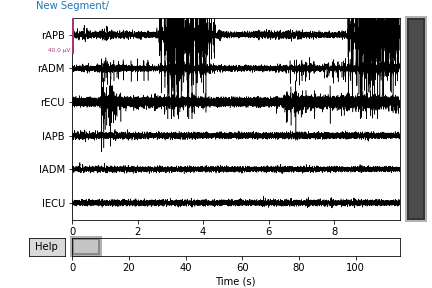

In [ ]:
#to plot
try:
    notch.plot(highpass=10, lowpass=2200)
except: 
    raw.plot()

## Find movement ALGO

__1. Setup AlGO parameters__

1.1. Select trail part of data with 3-5 movements 

In [ ]:
# adjast
muscle = 'rAPB'
start_trial = 8000
end_trial = 23000


# no changes
dat = raw.filter(l_freq=5, h_freq=2200, verbose=False).to_data_frame()[(raw.filter(l_freq=5, h_freq=2200,verbose=False).to_data_frame().time>=start_trial)&(raw.filter(l_freq=5, h_freq=2200,verbose=False).to_data_frame().time<=end_trial)]


Plot Trial signal

In [ ]:
# no change
fig, (ax0) = plt.subplots(nrows=1)
ax0.plot(dat.time, dat[str(muscle)])

2. Adjast. parameters (active msck, thrs, thrs2)

In [ ]:
# ADJUST

# 1.muscle
mscl = 'rAPB' #rapb

# 2. Thresholds, (absolut value) uV activity threshold which concidered as a movement 
# thrs - general, thrs2 is more accurate in subwindow 
thrs = 27 
thrs2 = 10


# 3. time window to analyse (ms)
# 650 is optimal 
window = 650 

# 4. percentage of picks which should be higher than thrs in the window 
# 0.05 is optimal
positive = 0.05 


3. Try algo settings on trial data at first.

In [ ]:
# no changes
# start and end in ms
trial_time = [start_trial, end_trial]
# Run algo on trial data
trial_movement_time, trial_data = find_movement(raw, trial_time, 'rAPB', window, thrs, thrs2, positive)


In [ ]:
# plot trial
plot_signal(trial_data, trial_movement_time)

__If the Movement start is not acurate enough, Adjast thrs,thrs2 and try again #2__

4. Apply to the whole recording (here time = [0] which means "start from 0 second"

In [ ]:
movement_time, data = find_movement(raw, [0], 'rAPB', window, thrs, thrs2, positive)

In [ ]:
# plot Algo Markup way1
plot_signal(data, movement_time)

## Manual adjastment of Algo Movement Markup

In [ ]:
# plot Algo Markup way2
plot_emg_events(raw, movement_time)

__1. save number of events to redo__

In [ ]:
# change
redo = [13,21,27,29,37]

In [ ]:
# no change
events = create_events(movement_time)

In [ ]:
events[events.event_name.isin(redo)].reset_index().time

__2. Manually adjast movement markup__

In [ ]:
new_timings = adjust_movements(events[events.event_name.isin(redo)].reset_index().time)

__3. Save Movement times to Google sheet together with adjasted__

In [ ]:
# change
sheet_name = 'trial_colab'

corrected_time = gsheet(sheet_name, new_timings)

__See movement times in the file:__

https://docs.google.com/spreadsheets/d/1g0wJeyONCuivtppNc352MBkBIyOgY7FxkQq5XgaBjsg/edit?usp=sharing

In [ ]:
corrected_time

## Plot signal with final movement start Markups

In [ ]:
plot_emg_events(raw, corrected_time.final_corrected_movement_time)

# Movement time found - the end